### Introduction:

This mini project will be a case study in Natural Language Processing through disaster tweets from Twitter. This will involve exploring a train and test dataset available on Kaggle, collected from Twitter, and contains the columns of id, text, location, keyword, and target (train set only). It includes 10,000 tweets that were hand classified. A machine learning model will be built and trained to predict which tweets are about real disasters and which are not. 

Natural Language Processing (NLP) can encompass many different techniques that can help machines learn from text. It has been used in search engines, chatbots, machine translation, and sentiment analysis. We will begin by loading in the data and explore the tweets. 

https://github.com/aryanbashar/NLP_Disaster_Tweets

### Required Packages and Tools:

In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.layers import LSTM
from keras.optimizers import RMSprop
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import nltk
import re
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')

### Load in and Describe the Data:

In [97]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


### Exploratory Data Analysis:

In [4]:
# Check the first 5 data rows in the training set
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


We can see that there are various texts here. The tweets have captials, hashtags, and stop words that could be removed.

In [91]:
# Check the first 5 data rows in the testing set
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [98]:
# Get the length of the text column in train set, with further information
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64


In [99]:
# Get the length of the text column in test set, with further information
print("Test Length Stat")
print(df_test["length"].describe())

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


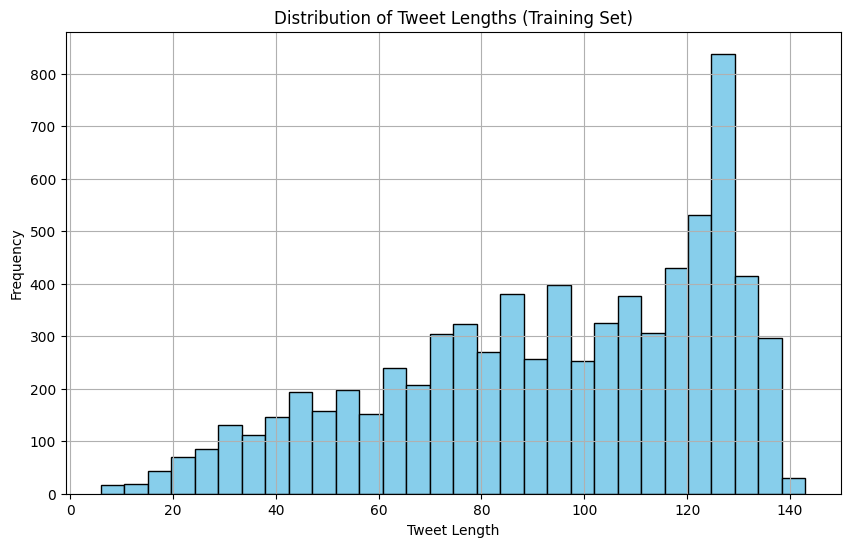

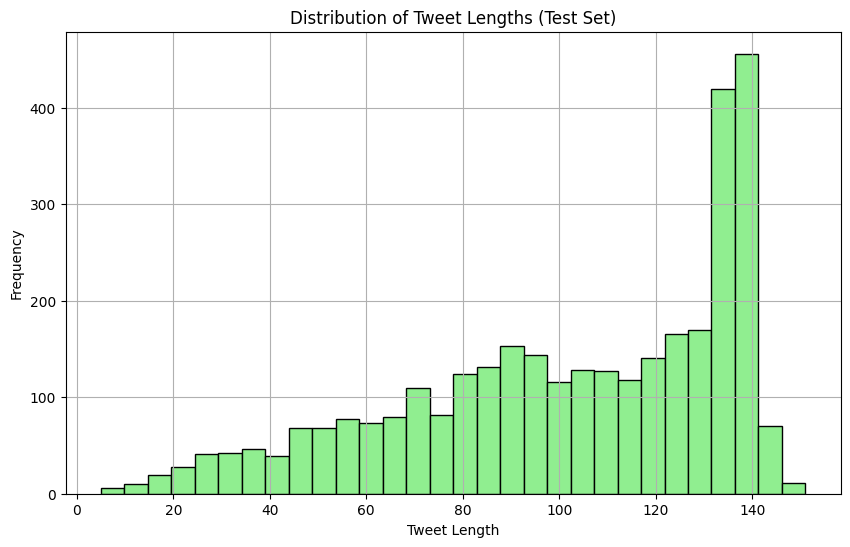

In [75]:
# Visualize the length of tweets in the training set
plt.figure(figsize=(10, 6))
plt.hist(df_train['length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Tweet Lengths (Training Set)')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Visualize the length of tweets in the testing set
plt.figure(figsize=(10, 6))
plt.hist(df_test['length'], bins=30, color='lightgreen', edgecolor='black')
plt.title('Distribution of Tweet Lengths (Test Set)')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

We can see that most tweets in both the training set and test set have the longest tweet lengths at between 130 to 140 characters. It looks that the frequency of tweets also go up as tweet lengths go up. 

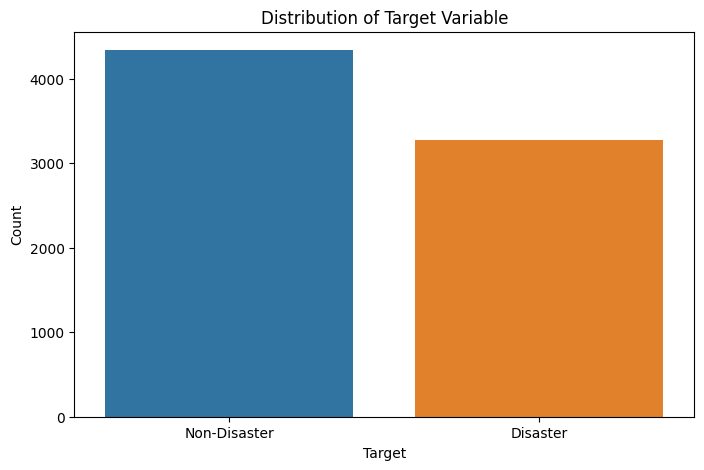

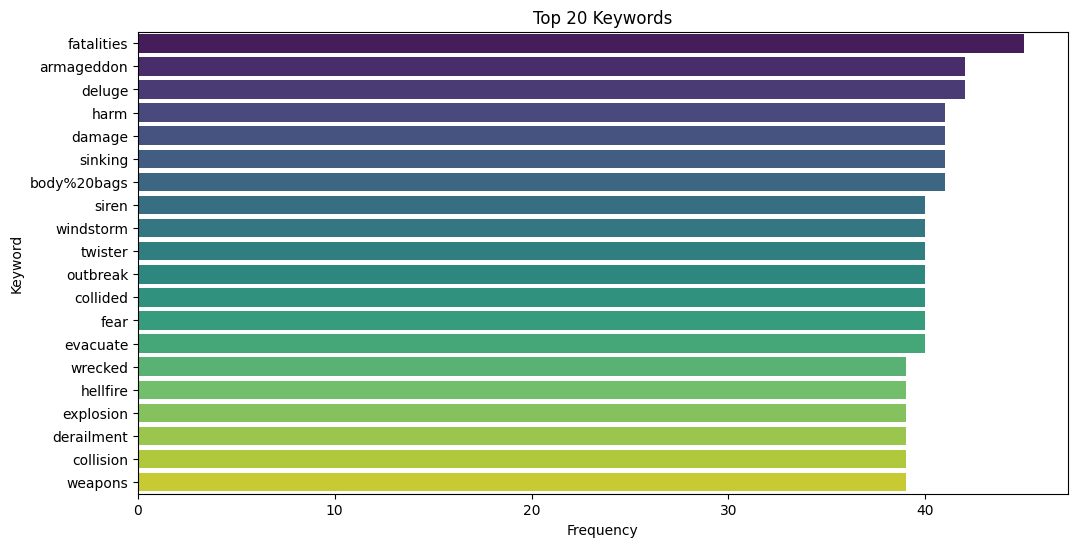

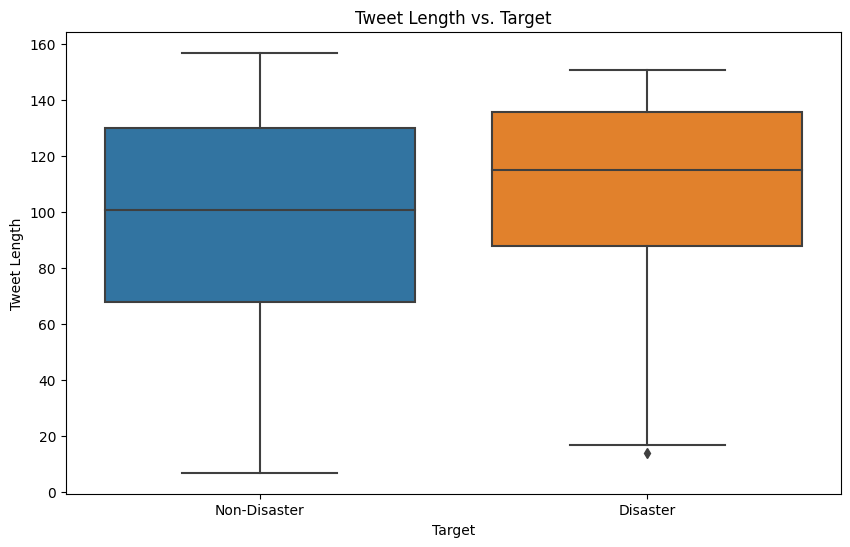

In [9]:
# Target Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='target', data=df_train)
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Disaster', 'Disaster'])
plt.show()

# Keyword Analysis
plt.figure(figsize=(12, 6))
top_keywords = df_train['keyword'].value_counts().head(20)
sns.barplot(x=top_keywords.values, y=top_keywords.index, palette='viridis')
plt.title('Top 20 Keywords')
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.show()

# Tweet Length vs. Target
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='length', data=df_train)
plt.title('Tweet Length vs. Target')
plt.xlabel('Target')
plt.ylabel('Tweet Length')
plt.xticks([0, 1], ['Non-Disaster', 'Disaster'])
plt.show()

There look to be more non-disaster tweets than disaster tweets. We can look to balance that our for our model. Based on the keywords, we can see that many disaster related words are on the highest frequency of keywords. Disaster tweets are generally longer than non-disaster tweets as well.

#### Cleaning Data Steps:

In [100]:
# Check for missing values
df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
length         0
dtype: int64

In [101]:
# Check for duplicates in the training data
print('Duplicates in Training Data', df_train.duplicated(subset=['text']).sum())

Duplicates in Training Data 110


In [102]:
# Remove duplicates from the training data 
df_train.drop_duplicates(subset=['text'], inplace=True)

# Verify that duplicates have been removed
print('Duplicates removed. New shape of training data:', df_train.shape)

Duplicates removed. New shape of training data: (7503, 6)


In [103]:
# Remove leading and trailing spaces from the 'text' column
df_train['text'] = df_train['text'].str.strip()

In [104]:
# Remove Special Characters
def remove_special_characters(text):
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

df_train['text'] = df_train['text'].apply(remove_special_characters)

In [72]:
# Remove hyphens from the text

def remove_hyphens(text):
    return text.replace('-', '')

df_train['text'] = df_train['text'].apply(remove_hyphens)

In [106]:
# Lowercase all text
df_train['text'] = df_train['text'].str.lower()

In [107]:
df_train.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,69
1,4,NaN,NaN,forest fire near la ronge sask canada,1,38
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,133
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1,65
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,88


The text column looks ready now for preprocessing and then model building.

### Preprocessing:

Tokenizing is a preprocessing step that involves a system that looks at the text and breaks it down into smaller units called tokens. This is an important step for natural language processing since it helps convert text to a structure that can be treated by a deep learning model. It will explore the data and assign an ID to each word or token so when it is converted to a numerical shape, the tokenizer can match each word in the text to an ID. 

In [108]:
# Tokenize the text data in the training set
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['text'])

In [109]:
# Convert text data to sequences
sequences = tokenizer.texts_to_sequences(df_train['text'])

In [110]:
# Pad sequences to ensure uniform length
max_sequence_length = 150
X_train = pad_sequences(sequences, maxlen=max_sequence_length)

In [125]:
# Tokenize text data in the testing set
sequences_test = tokenizer.texts_to_sequences(df_test['text'])

# Pad sequences for uniform length
X_test = pad_sequences(sequences_test, maxlen=max_sequence_length)

# Get the predicted target values from the trained model
test_predictions = model.predict(X_test)

102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step


### Building and Training the Model:

We separated the dataset into training and validation sets and then built the model. We use a deep learning model in Python called Keras which uses built in Recurrent neural network (RNN) layers, which are a class of networks that are powerful for modeling sequence data like natural language. This makes it useful for this project as it loops through sequences. The Embedding layer maps each integer-coded word to a vector representation and use those to discover semantic relationships between words. The SpatialDropout helps with overfitting by reducing a random amount of input units, with 20% being dropped in this case. The Long Short-Term Memory (LSTM) layer is RNN units that can learn long-term dependencies, which is useful for understanding the context of words within a longer text. The final Dense Layer with Sigmoid Activation provides a probability score between 0 and 1 for the likelihood of a text belonging into either positive or negative sentiment. The model is then compiled, and an Adam optimizer is used which revises the learning rate throughout training for faster converging. 

In [111]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, df_train['target'], test_size=0.2, random_state=42)

In [112]:
# Define model architecture
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

In [113]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [114]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), verbose=1)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 226ms/step - accuracy: 0.6041 - loss: 0.6523 - val_accuracy: 0.7781 - val_loss: 0.4953
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 225ms/step - accuracy: 0.8477 - loss: 0.3657 - val_accuracy: 0.7875 - val_loss: 0.4768
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 229ms/step - accuracy: 0.9206 - loss: 0.2128 - val_accuracy: 0.7775 - val_loss: 0.5183
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 226ms/step - accuracy: 0.9613 - loss: 0.1176 - val_accuracy: 0.7768 - val_loss: 0.5992
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 225ms/step - accuracy: 0.9784 - loss: 0.0670 - val_accuracy: 0.7768 - val_loss: 0.7459
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 226ms/step - accuracy: 0.9871 - loss: 0.0417 - val_accuracy: 0.7755 - val_loss: 0.7813
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 225ms/step - accuracy: 0.9936 - loss: 0.0231 - val_accuracy: 0.7755 - val_loss: 0.8309
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 225ms/step - accuracy: 0.9969 - loss: 0.0163 - val_accu

In [115]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.7573 - loss: 1.0754
Validation Loss: 1.0268858671188354
Validation Accuracy: 0.7694870233535767


Based on the validation loss of approximately 1.03 and validation accuracy of approximately 0.770, we can say that the model performs reasonably well on the validation dataset. We can check how these numbers compared over each epoch of the training.

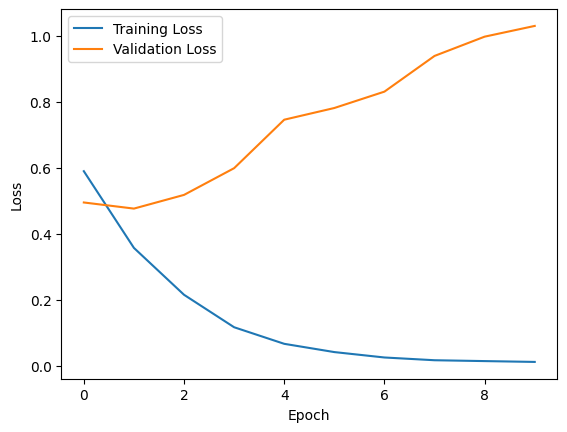

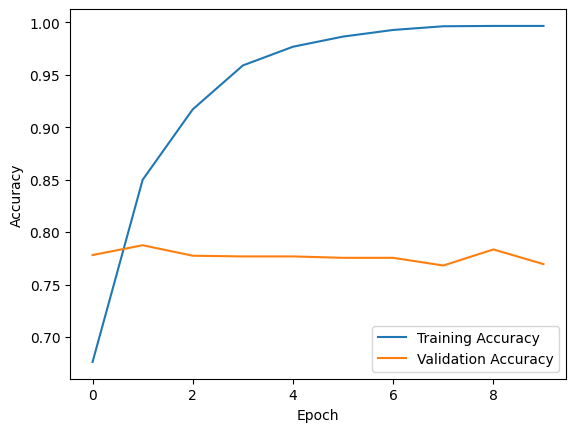

In [116]:
# Plot Epoch vs. Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Epoch vs. Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Model 2:
Let see if we can improve the validation accuracy and lower the validation loss. Let us compare the previous model with the below model that uses a Bidirectional Long Short-Term Memory layer and then one with a Stacked LSTM instead. This bidirectional layer would mean that sequences are processed in both directions and may allow it to gather more information from all states. The stacked LSTM instead introduces more complexitiy through multiple layers, and learns from each previous layer and learn more abstract representations from the input. We will keep the rest of the parameters the same and change if needed. 

In [117]:
# Define model architecture with Bidirectional LSTM
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), verbose=1)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 37s 358ms/step - accuracy: 0.6090 - loss: 0.6497 - val_accuracy: 0.7555 - val_loss: 0.4987
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 33s 355ms/step - accuracy: 0.8521 - loss: 0.3664 - val_accuracy: 0.7821 - val_loss: 0.4795
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 356ms/step - accuracy: 0.9238 - loss: 0.2116 - val_accuracy: 0.7888 - val_loss: 0.5317
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 33s 355ms/step - accuracy: 0.9593 - loss: 0.1234 - val_accuracy: 0.7775 - val_loss: 0.6730
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 33s 354ms/step - accuracy: 0.9742 - loss: 0.0779 - val_accuracy: 0.7635 - val_loss: 0.7675
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 33s 352ms/step - accuracy: 0.9877 - loss: 0.0446 - val_accuracy: 0.7688 - val_loss: 0.7903
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 33s 353ms/step - accuracy: 0.9914 - loss: 0.0290 - val_accuracy: 0.7735 - val_loss: 0.9110
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 33s 355ms/step - accuracy: 0.9951 - loss: 0.0200 - val_accu

In [118]:
# Define model architecture with stacked LSTM
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), verbose=1)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 44s 419ms/step - accuracy: 0.6152 - loss: 0.6434 - val_accuracy: 0.7848 - val_loss: 0.4708
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 39s 416ms/step - accuracy: 0.8596 - loss: 0.3432 - val_accuracy: 0.7888 - val_loss: 0.4772
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 39s 416ms/step - accuracy: 0.9340 - loss: 0.1868 - val_accuracy: 0.7728 - val_loss: 0.5672
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 39s 411ms/step - accuracy: 0.9585 - loss: 0.1168 - val_accuracy: 0.7695 - val_loss: 0.7035
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 39s 414ms/step - accuracy: 0.9769 - loss: 0.0669 - val_accuracy: 0.7642 - val_loss: 0.7573
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 39s 415ms/step - accuracy: 0.9911 - loss: 0.0330 - val_accuracy: 0.7742 - val_loss: 0.8508
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 40s 423ms/step - accuracy: 0.9934 - loss: 0.0212 - val_accuracy: 0.7722 - val_loss: 1.0085
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 39s 417ms/step - accuracy: 0.9955 - loss: 0.0181 - val_accu

In [119]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.6928 - loss: 1.2673
Validation Loss: 1.2277848720550537
Validation Accuracy: 0.7228514552116394


### Results:

Interestingly, our first model with the single LSTM layer performed the best. The more advanced models performed worse. Based on the validation loss and accuracy above, it had the highest number. Let us adjust the parameters on that one then to see if it can improve any more. Let us change the output dimension to 50 from 100 which will reduce dimensionality of word embeddings. The dropout rate will also be increase by 10% to counteract overfitting further. The LSTM layer was increased to 200 units which should improve the model’s ability to learn from the inputted data. The optimizer was also changed from Adam to RMSprop, which is renowned for its adaptive learning rate performance. Let us see how it performs. 

In [120]:
# Define model architecture
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=50))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(200, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with RMSprop optimizer
optimizer = RMSprop(learning_rate=0.001)  # You can adjust the learning rate as needed
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_val, y_val), verbose=1)


Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 226ms/step - accuracy: 0.5591 - loss: 0.6837 - val_accuracy: 0.6043 - val_loss: 0.6643
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 219ms/step - accuracy: 0.6395 - loss: 0.6486 - val_accuracy: 0.6942 - val_loss: 0.5790
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 214ms/step - accuracy: 0.7445 - loss: 0.5333 - val_accuracy: 0.7662 - val_loss: 0.5141
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 221ms/step - accuracy: 0.8221 - loss: 0.4345 - val_accuracy: 0.7835 - val_loss: 0.4904
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 224ms/step - accuracy: 0.8565 - loss: 0.3613 - val_accuracy: 0.7788 - val_loss: 0.4833
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 218ms/step - accuracy: 0.8749 - loss: 0.3210 - val_accuracy: 0.7595 - val_loss: 0.5089
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 220ms/step - accuracy: 0.8899 - loss: 0.2816 - val_accuracy: 0.7695 - val_loss: 0.5269
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 222ms/step - accuracy: 0.8925 - loss: 0.2828 - val_accu

In [121]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.7620 - loss: 0.6104
Validation Loss: 0.5846244096755981
Validation Accuracy: 0.774150550365448


Validation accuracy improved only slightly, but there was a large improvement in validation loss. 

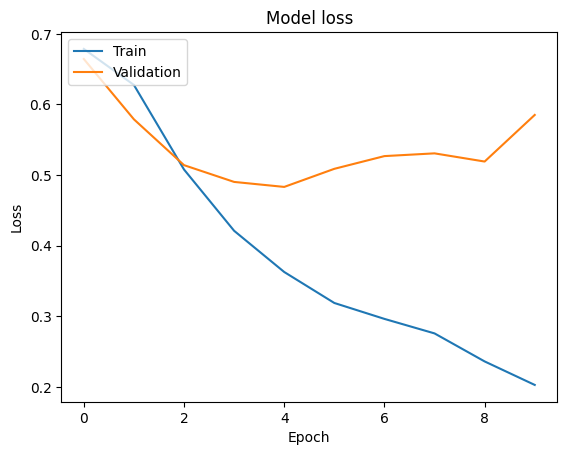

In [122]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

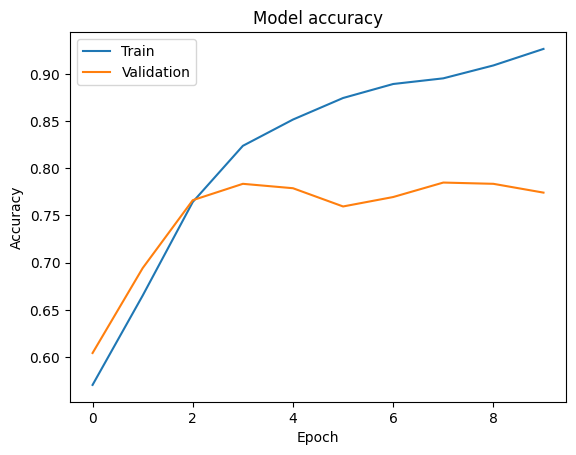

In [123]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

The Receiver Operating Characteristic (ROC) and Precision-Recall curves can provide valuable information on the performance of the model. The ROC curve shows the trade-off on when the model correctly classifies a text and when it does not. The two sides are respectively called True Positive Rate and False Positive Rate. The area under the curve would then show the performance of the model. A Precision-Recall curve shows the trade off between precision and recall. Precision would be the proportion of true positive predictions to all other predictions, while recall is proportion of true positive predictions with all actual positive instances. The area under this curve similarily can calculate peformance of the model. 

47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step


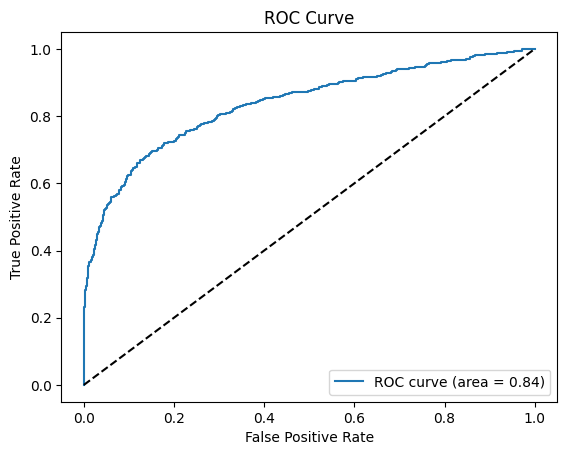

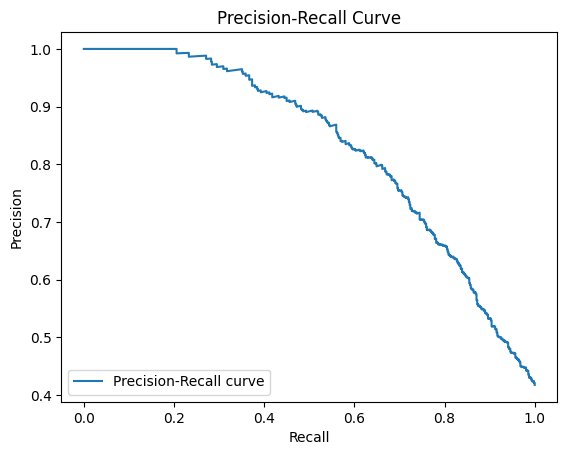

In [124]:
# Get the predicted probabilities for the positive class
y_pred_probability = model.predict(X_val)

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_val, y_pred_probability)

# Calculate the Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_val, y_pred_probability)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Plot the Precision-Recall curve
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

## Analysis:

The single LSTM layer model worked the best compared to the Bidirectional LSTM and Stacked LSTM, even prior to tuning. This could be due to multiple reasons. The data may not have been complex enough for benefits to be seen with the different layers, and if complex relationships are not concerned then a simpler model may perform better. Also, if the data is limited then a more complex model could introduce overfitting and so the testing would not be as suitable on unseen data. They would require more data to successfully learn from them as well. The more complex could also require more specific hyperparameter tuning to get to an optimal performance than can match or exceed a simple layer. It could have been a case of randomness as well, and if further test were done, then we may have seen the other models perform better. 

The final choice model achieved a validation loss of approximately 0.585 and a validation accuracy of 0.774. Based on the loss, the model is performing reasonably well and is predicant relatively close to the true labels. The accuracy  indicates that the model accurately categorized about 76.89% of the validation dataset. There is room for improvement, especially with further hyperparameter tuning and further preprocessing. The area under the curve of the ROC curve was 0.84, which suggests a respectable execution of the classification model. Based on the precision-recall curve, there is definitely area for correction. 

## Conclusion:

This mini-project in natural language processing and text classifying allowed for a delve into deep learning models. Tweets from one of the most prominent social media sites can be used to challenge data scientists in their field. Building and training a model to differentiate between what is a disaster tweet or not is especially interesting, as language can have many words that have multiple meanings that may sometimes be difficult for a model. As expressed in this project, the model with a single LSTM layer outperformed the more complex models that consisted of a Bidirectional LSTM and a Stacked LSTM. As the data was not overly complicated and was not large, this could have been why the simpler model performed better. The tuning of the parameters also helped mostly with decreasing validation loss, but the effect on accuracy was limited. In the future, I hope to look at further ways to improve the model by introducing more preprocessing steps that would help the model understand the data. Likewise, I can try different model architectures that may perform better for classifying text from smaller datasets. Overall, this project provided a means to explore natural language processing in a controlled Kaggle environment and provided beneficial knowledge in how different model architectures can work. It is clear that utilizing the newest and most complex model is not always required in each situation and a data scientist to take each dataset as a new opportunity.

## Citation:

Addison Howard, devrishi, Phil Culliton, Yufeng Guo. (2019). *Natural Language Processing with Disaster Tweets.* Kaggle. https://kaggle.com/competitions/nlp-getting-started

Chicco D. (2017). Ten quick tips for machine learning in computational biology. *BioData mining*, 10, 35. https://doi.org/10.1186/s13040-017-0155-3

Staudemeyer, R. C., & Morris, E. R. (2019). Understanding LSTM -- a tutorial into Long Short-Term Memory Recurrent   Neural Networks. *arXiv (Cornell University)*. https://doi.org/10.48550/arxiv.1909.09586

### Submit to Kaggle Code:

In [126]:
# Convert the predicted probabilities to binary predictions (0 or 1)
test_predictions = (test_predictions > 0.5).astype(int)

In [128]:
# Get the "id" column from df_test
submission_ids = df_test['id']

# Create a DataFrame for submission
submission_df = pd.DataFrame({
    "id": submission_ids,
    "target": test_predictions.flatten()  # Flatten the predictions to convert to a 1D array
})

# Display the first few rows of the submission DataFrame
print(submission_df.head())

   id  target
0   0       0
1   2       1
2   3       1
3   9       0
4  11       1


In [129]:
# Save the DataFrame to a CSV file
submission_df.to_csv("submission.csv", index=False)